In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [409]:
def time_conversion(dataset,column,conversion_factor=0.0001):
    '''Converts the timestamps in the dataset from 0.1ms (spike recording resolution) to seconds (0.0001)'''
    dataset[column] = dataset[column]*conversion_factor
    return dataset

def start_interval_from_zero(dataset):
    '''Subtracts the first timestamp value from all timestamps, so spike times begin from zero onward'''
    new_zero = dataset['timestamp'].min()
    dataset['timestamp'] = dataset['timestamp'].apply(lambda x: x - new_zero)
    return dataset

def number_of_trials(behaviour_dataset):
    '''Returns the number of trials for a given session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: the number of trials
    '''
    return len(behaviour_dataset)

def trials_begin_end(behaviour_dataset):
    '''Returns the number of trials for a given session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: a list of tuples (trial_start,trial_end)
    '''
    n_trials = number_of_trials(behaviour_dataset)
    boundaries = []
    for trial in range(n_trials):
        lower_boundary = behaviour_dataset.iloc[trial].trial_start
        upper_boundary = behaviour_dataset.iloc[trial].trial_end
        boundaries.append((lower_boundary,upper_boundary))
    return boundaries

def spikes_in_interval(dataset,interval_start,interval_end):
    '''Returns all spikes in the dataset whose timestamps lay between the interval start and end boundaries
    
    INPUT: a Pandas DataFrame containing the spike data from the SpikeData.dat file of the corresponding session
    and the time boundaries that define the interval
    OUTPUT: a Pandas DataFrame containing the subset of spikes_dataset whose timestamps lie within the boundaries
    '''
    return dataset.loc[(dataset['timestamp'] >= interval_start) &
                       (dataset['timestamp'] <= interval_end)]

def separate_into_trials(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each trial in the session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each trial
    '''
    trials = []
    time_boundaries = trials_begin_end(behaviour_dataset)
    
    for trial in range(number_of_trials(behaviour_dataset)):
        trial_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][0],time_boundaries[trial][1])
        #trial_spikes = start_interval_from_zero(trial_spikes)
        trials.append(trial_spikes)
    
    return trials

def build_ITIs(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each ITI in the session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each ITI
    '''
    ITIs = []
    time_boundaries = trials_begin_end(behaviour_dataset)
    
    for trial in range(number_of_trials(behaviour_dataset)-1):
        ITI_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][1],time_boundaries[trial+1][0])
        ITI_spikes = start_interval_from_zero(ITI_spikes)
        ITIs.append(ITI_spikes)
    return ITIs

def delete_neurons(spikes_dataset,threshold = 3):
    '''Deletes neurons that spike less than three times in a trial
    
    INPUT: spikes DataFrame and a threshold [int] of the minimum number of spikes for the neuron to be considered
    OUTPUT: the same spikes_dataset structure (a Dataframe with two columns) but without the low-activity neurons
    ''' 
    
    neurons = spikes_dataset['cell'].unique()
    
    for neuron in neurons:
        #prevents neurons from less than threshold (in this case, 3) spikes from being further analysed 
        if len(spikes_dataset.loc[spikes_dataset['cell'] == neuron]) > threshold:    
            #print('there are ',len(spikes_dataset.loc[spikes_dataset['cell'] == neuron]),' spikes for neuron',neuron)
            continue
        else:
            spikes_dataset = spikes_dataset.drop(spikes_dataset[spikes_dataset['cell'] == neuron].index)
            #print('Discarded neuron:',neuron)
    return spikes_dataset

def neurons_in_all_trials(trials_dataset):
    '''Checks the global intersection in the sets of neurons that are active in each trial
    
    INPUT: A dataset that is spikes_data-like but split between trials, as returned by separate_into_trials()
    OUTPUT: A list whose elements are the neurons that are active in each and every trial'''
    
    labels = []
    for trial in trials_dataset:
        labels.append(trial.cell.unique())

    sets = [set(label) for label in labels]
    test_set = sets.pop(0)

    for neurons in sets:
        test_set.intersection_update(neurons)
    return np.array(list(test_set))

def separate_neurons(spikes_dataset):
    '''Splits the dataset into a list whose elements are the subsets comprising the spikes of each neuron
    
    INPUT: spikes DataFrame with two colums (timestamps for spikes and whose neuron it is)
    OUTPUT: a list whose elements are the subsets of the spikes Dataframe (with the same structure) for each neuron
    ''' 
    
    neurons = spikes_dataset['cell'].unique()
    split_dataset = []
    
    for neuron in neurons: 
        split_dataset.append(spikes_dataset.loc[spikes_dataset['cell'] == neuron])
    return split_dataset

def isi_estimate(spike_times):
    '''Estimates the inter-spike interval (ISI) from a list of spike times (i.e. spikes_data['timestamp'])
    
    INPUT: A list of the instants in which spikes were fired
    OUTPUT: A list of inter-spike intervals for adjacent events'''

    isi = []
    for timestamp in range(len(spike_times)-1):
        current_isi = spike_times[timestamp+1] - spike_times[timestamp]
        isi.append(current_isi)
    return isi

def spike_train_shuffling(spike_times):
    '''
    Shuffles the inter-spike intervals (ISI) in a spike train. Indeed, this preserves the number of spikes,
    the total duration spanned by the spiking activity, the ISI distribution, and the mean rate. On the other hand,
    this annihilates any temporal structure in the spiking activity that could subserve some function.
    
    INPUT: a spike train, as given by a list of the timestamps of instants in which a spike occurs
    OUTPUT: another spike train with the same ISI distribution and number of spikes but shuffled spike positions'''
    
    #just in case it is passed as a DataFrame column and not a list
    spike_times = list(spike_times)
    
    #obtain the ISI
    isi_distribution = isi_estimate(spike_times)
    #and shuffle it
    random.shuffle(isi_distribution)
    
    '''since all spike trains are set to begin at t=0, setting the first spike to happen at t=0 is not a problem
    if this is not the case, select a random number - but beware this might make some spike trains longer'''
    current_spike = spike_times[0]
    
    new_spike_train = []
    
    for isi in isi_distribution:
        new_spike_train.append(current_spike)
        #the next spike will be positioned 
        current_spike += isi

    return new_spike_train

def kernel_conv(kernel,current_time,spike_time,resolution):
    if kernel == 'rectangular':
        temporal_displacement = abs(current_time - spike_time)
        if temporal_displacement < resolution:
            return 1/resolution
        else:
            return 0
    
    elif kernel == 'gaussian':
        temporal_displacement = abs(current_time - spike_time)
        return np.exp(-temporal_displacement**2/(2*resolution**2))/resolution*np.sqrt(2)
    
    elif kernel == 'alpha':
        temporal_displacement = current_time - spike_time
        if temporal_displacement > 0:
            return (temporal_displacement/resolution**2)*np.exp(-temporal_displacement/resolution)
        else:
            return 0
    else:
        raise Exception("Invalid kernel.")

def windowed_signal(spike_times,starting_point=0,sampling_rate=0.01,kernel='gaussian',resolution=1.5):
    '''
    INPUT:
    starting_point: first timepoint [float]
    sampling_rate: 1/# of points in which we shall estimate our firing rate [float]
    kernel: the kernel each spike shall be convolved with (options: rectangular, gaussian and alpha) [string]
    resolution: the parameter controlling the width of the window (i.e. sigma in the gaussian kernel,
        window width in the rectangular kernel) [float]
    spike_times: an array containing the timestamp for each spike [list(float)]
    
    OUTPUT:
    rates: an array containing the estimated spiking rate at each timepoint [list(float)]
    '''
    current_time = starting_point
    rates = []
    
    while current_time <= max(spike_times):
        current_time += sampling_rate
        contribution_to_rate = []
        '''We calculate the contribution each spike in the train (instant) makes to the firing rate estimated at
        time (current_time) by convolving the spike with a given kernel, considering the temporal displacement
        between them.

        Larger temporal displacements should yield less contribution to the rate estimate, whereas spikes closer
        to the timepoint we are interested in should yield a larger contribution.'''
        for spike_timestamp in spike_times:
            contribution_to_rate.append(kernel_conv(kernel,current_time,spike_timestamp,resolution=resolution))

        #Sum the contributions of all spikes to achieve the rate estimate at time current_time
        current_rate = np.sum(contribution_to_rate)
        #Which we append to our rates list, which will yield our firing rate (hz) x time (s) plot afterwards
        rates.append(current_rate)
    return rates

In [410]:
#Fetch (in order) the session/trial pair in which learning occurred
learning_trial_number = [23,23,14,5,10,12,5,18,11,8]
analyse_trial_session = ['201222','201227','201229','181012','181020',
                            '150628','150630','150707','190214','190228']

In [411]:
#Zip these two lists so the elements will be paired into tuples (session,trial)
learning_events = zip(analyse_trial_session,learning_trial_number)

In [412]:
#1 second bins for population rate histogram? Seems reasonable
binsize = 1

In [413]:
#load data
behaviour_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_Behavior.dat',
                     header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python') #Behaviour.dat dataset
spikes_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_SpikeData.dat',
                     header=None,names=['timestamp','cell'],engine = 'python') #SpikeData.dat dataset

In [414]:
#adjust times from ms to s
spikes_dataset = time_conversion(spikes_dataset,'timestamp') #timestamps now in seconds
behaviour_dataset = time_conversion(behaviour_dataset,'trial_start') #trial_start now in seconds
behaviour_dataset = time_conversion(behaviour_dataset,'trial_end') #trial_end now in seconds

In [415]:
#number of trials and their time boundaries
n_trials = number_of_trials(behaviour_dataset)
trial_intervals = trials_begin_end(behaviour_dataset)

In [416]:
#split the spikes_dataset into separate trials and ITIs
trials = separate_into_trials(behaviour_dataset,spikes_dataset)
ITIs = build_ITIs(behaviour_dataset,spikes_dataset)

/tmp/ipykernel_180678/375594003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['timestamp'] = dataset['timestamp'].apply(lambda x: x - new_zero)


In [417]:
#drop neurons that spike less than three times in a trial/ITI
trials = list(map(delete_neurons,trials))
ITIs = list(map(delete_neurons,ITIs))

In [418]:
#find the intersection of neurons that are active at every trial/ITI
neurons_trials = neurons_in_all_trials(trials)
neurons_ITIs = neurons_in_all_trials(ITIs)

In [441]:
#remove neurons that are not active in all trials
for trial in range(len(trials)):
    trials[trial] = trials[trial].loc[trials[trial].apply(lambda x: x.cell in neurons_trials,axis = 1)]

In [444]:
#divide each element (trial) in the trials list in its constituent neurons
spike_trains = []
for trial in trials:
    spike_trains.append(separate_neurons(trial))

In [850]:
#for an instance: this yields the dataframe of the second neuron (cell = 5) in trial 0
spike_trains[0][1]
#whereas this is for the first neuron (cell = 2) in the second trial
spike_trains[1][0]

In [851]:
#testando a convolução com os spikes de um único neurônio (cell = 5) em uma única trial (trial 0)
firing_times = np.array(spike_trains[0][1]['timestamp'])

In [852]:
firing_times

array([204.6845 , 204.69225, 204.69692, 204.7039 , 204.70933, 204.7241 ,
       204.73035, 204.73244, 204.74295, 204.74514, 204.74787, 204.75411,
       204.76147, 204.76907, 204.77386, 204.77942, 204.781  , 204.78569,
       204.7959 , 204.80077, 204.81266, 204.8194 , 204.82901, 204.8394 ,
       204.85991, 204.87395, 204.88106, 204.88938, 204.8969 , 204.90277,
       204.90791, 204.91228, 204.91725, 204.92235, 204.92904, 204.93688,
       204.94114, 204.94654, 204.95086, 204.95502, 204.95789, 204.96011,
       204.96443, 204.9659 , 204.97245, 204.9778 , 204.98315, 204.98889,
       204.9934 , 205.00155, 205.00507, 205.01069, 205.01317, 205.01674,
       205.02105, 205.02728, 205.03313, 205.03597, 205.03776, 205.04005,
       205.04485, 205.04785, 205.05053, 205.05433, 205.06378, 205.06919,
       205.07473, 205.07739, 205.08332, 205.08969, 205.09548, 205.10072,
       205.10439, 205.11195, 205.11531, 205.11923, 205.12506, 205.13251,
       205.13482, 205.13862, 205.14119, 205.14543, 

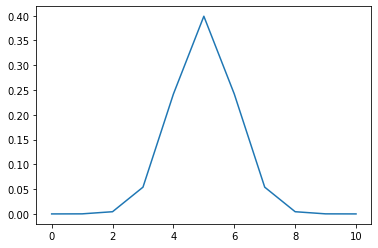

In [884]:
#fazendo o kernel gaussiano
import math

#resolução = sigma (em s)
sigma = 1 #gaussian sigma = std/bins, here std being 100ms and bins being 100ms

sampling_timepoints = np.arange(start=-5*sigma, stop = 5*sigma+1, step = 1)
resolution_constant = 2 * sigma**2
normalisation_constant = 1/(np.sqrt(np.pi*resolution_constant))

#a contribuição de cada ponto de sampling
kernel = normalisation_constant * np.exp(-((sampling_timepoints**2)/resolution_constant))
#o kernel deve ter área 1, então:
kernel = kernel/np.sum(kernel)
plt.plot(kernel)

In [885]:
#aqui há uma leve discrepância: os máximos e mínimos que estou usando não são os máximos e mínimos da trial
#mas os desse neurônio; não foi isso que ocasionou o problema de binning porque também é o que eu usei no Matlab
T_begin = min(firing_times)
T_end = max(firing_times)

T_period = T_end - T_begin
T = [T_begin, T_end]

#o jeito :S que eles fazem:
#T = [T_begin + 0*T_period,T_end + 1*T_period];

#a ser apurada qual a realidade aqui
bin_size = 0.01

In [886]:
'''eles fazem da seguinte maneira:

bins = np.arange(T[0] + bin_size/2,T[1] - bin_size/2,bin_size)

mas no python isso dá bins diferentes; podes comparar usando o código do octave que mando junto
'''

bins = np.arange(T[0],T[1],bin_size)

In [887]:
spk = np.histogram(firing_times,bins);
spk[0]

array([2, 2, 1, 1, 2, 1, 3, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 4, 2, 2, 2, 1, 3, 2, 2, 3, 4, 1, 1, 3, 1, 3, 1, 2,
       2, 3, 3, 1, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 1, 2, 1])

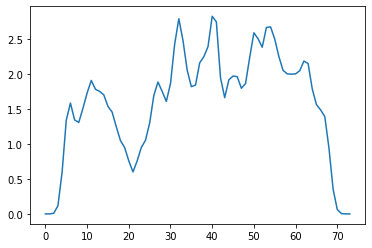

In [888]:
convolution = np.convolve(kernel,spk[0])
plt.plot(convolution)

(array([ 8.,  9.,  6.,  4.,  8., 12., 10., 12.,  9., 13., 11., 10.]),
 array([204.6845, 204.7345, 204.7845, 204.8345, 204.8845, 204.9345,
        204.9845, 205.0345, 205.0845, 205.1345, 205.1845, 205.2345,
        205.2845]),
 <BarContainer object of 12 artists>)

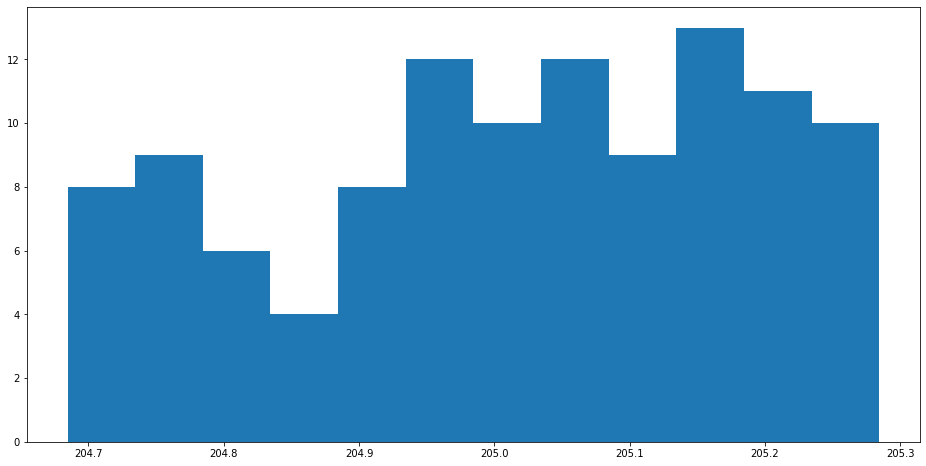

In [580]:
plt.figure(figsize=(16,8))
#plt.eventplot(firing_times)
bins = np.arange(min(firing_times),max(firing_times),step = 0.05)
plt.hist(firing_times,bins)

In [511]:
h = np.exp(((x.^2*(1/(2*sig^2)))))

In [ ]:
x = -5*sig:1:5*sig';  % x-axis values of the discretely sampled Gaussian, out to 5xSD
h = (1/(sqrt(2*pi*sig^2)))*exp(-((x.^2*(1/(2*sig^2))))); % y-axis values of the Gaussian

In [ ]:
def kernel_conv(kernel,current_time,spike_time,resolution):
    if kernel == 'gaussian':
        temporal_displacement = abs(current_time - spike_time)
        return np.exp(-(temporal_displacement**2/(2*(resolution**2))))/(resolution*np.sqrt(2))
    else:
        raise Exception("Invalid kernel.")

def windowed_signal(spike_times,starting_point=0,sampling_rate=0.01,kernel='gaussian',resolution=1.5):
    current_time = starting_point
    rates = []
    
    while current_time <= max(spike_times):
        current_time += sampling_rate
        contribution_to_rate = []
        '''We calculate the contribution each spike in the train (instant) makes to the firing rate estimated at
        time (current_time) by convolving the spike with a given kernel, considering the temporal displacement
        between them.

        Larger temporal displacements should yield less contribution to the rate estimate, whereas spikes closer
        to the timepoint we are interested in should yield a larger contribution.'''
        for spike_timestamp in spike_times:
            contribution_to_rate.append(kernel_conv(kernel,current_time,spike_timestamp,resolution=resolution))

        #Sum the contributions of all spikes to achieve the rate estimate at time current_time
        current_rate = np.sum(contribution_to_rate)
        #Which we append to our rates list, which will yield our firing rate (hz) x time (s) plot afterwards
        rates.append(current_rate)
    return rates

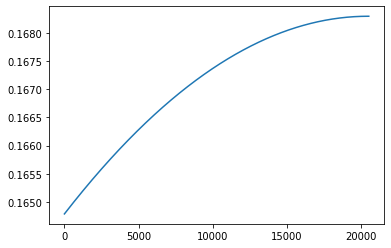

In [437]:
teste = trials[0]
teste = teste.loc[teste.apply(lambda x: x.cell in neurons_trials,axis = 1)]
teste

,timestamp,cell
24559,204.67083,2.0
24560,204.71147,2.0
24561,204.71921,2.0
24562,204.72679,2.0
24563,204.74334,2.0
...,...,...
1056259,205.07781,27.0
1056260,205.10686,27.0
1056261,205.14120,27.0
1056262,205.16796,27.0


In [394]:
print(min(trials[0]['timestamp']),max(trials[0]['timestamp']))

204.67054 205.33318000000003


In [363]:
teste[teste['cell'].isin(neurons_trials)]

,timestamp,cell
24559,2046.7083,2.0
24560,2047.1147,2.0
24561,2047.1921,2.0
24562,2047.2679,2.0
24563,2047.4334,2.0
...,...,...
1056259,2050.7781,27.0
1056260,2051.0686,27.0
1056261,2051.4120,27.0
1056262,2051.6796,27.0


In [362]:
def relevant_neurons(single_trial_df,neurons_to_consider):
    '''
    
    INPUT: a dataframe containing the spikes for every neuron in a given trial
    OUTPUT: the former dataframe without the rows corresponding to neurons that do not fire in every trial
    '''
    
    return single_trial_df.loc[single_trial_df.apply(lambda row: row.cell in neurons_to_consider,axis = 1)]

,timestamp,cell
24559,2046.7083,2.0
24560,2047.1147,2.0
24561,2047.1921,2.0
24562,2047.2679,2.0
24563,2047.4334,2.0
...,...,...
1056259,2050.7781,27.0
1056260,2051.0686,27.0
1056261,2051.4120,27.0
1056262,2051.6796,27.0


In [301]:
for trial in trials:
    print(trial)
    break

         timestamp  cell
24559    2046.7083   2.0
24560    2047.1147   2.0
24561    2047.1921   2.0
24562    2047.2679   2.0
24563    2047.4334   2.0
...            ...   ...
1056259  2050.7781  27.0
1056260  2051.0686  27.0
1056261  2051.4120  27.0
1056262  2051.6796  27.0
1056263  2051.7772  27.0

[1309 rows x 2 columns]


In [298]:
for trial in trials:
    for neuron in neurons_trials:
        print(trials[0].loc[trials[0]['cell']==neuron])
        break

       timestamp  cell
24559  2046.7083   2.0
24560  2047.1147   2.0
24561  2047.1921   2.0
24562  2047.2679   2.0
24563  2047.4334   2.0
24564  2047.5613   2.0
24565  2048.1830   2.0
24566  2048.5185   2.0
24567  2048.9053   2.0
24568  2048.9511   2.0
24569  2048.9921   2.0
24570  2049.0624   2.0
24571  2049.1406   2.0
24572  2049.1934   2.0
24573  2049.2199   2.0
24574  2049.2891   2.0
24575  2049.4397   2.0
24576  2049.4871   2.0
24577  2049.5746   2.0
24578  2049.5929   2.0
24579  2049.6805   2.0
24580  2049.7033   2.0
24581  2049.7889   2.0
24582  2050.1339   2.0
24583  2050.2061   2.0
24584  2050.2513   2.0
24585  2050.2631   2.0
24586  2050.3613   2.0
24587  2050.4901   2.0
24588  2050.5656   2.0
24589  2051.2773   2.0
24590  2051.4701   2.0
24591  2051.6593   2.0
24592  2051.6998   2.0
24593  2051.8380   2.0
       timestamp  cell
91763  2046.8450   5.0
91764  2046.9225   5.0
91765  2046.9692   5.0
91766  2047.0390   5.0
91767  2047.0933   5.0
...          ...   ...
91877  2052

In [291]:
spikes_teste = trials[0].loc[trials[0]['cell']==2]
teste2 = list(spikes_teste['timestamp'])
teste3 = spike_train_shuffling(teste2)

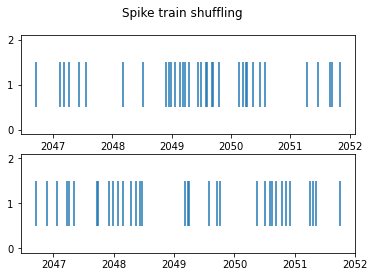

In [294]:
fig, axs = plt.subplots(2)
fig.suptitle('Spike train shuffling')
axs[0].eventplot(teste2)
axs[1].eventplot(teste3)

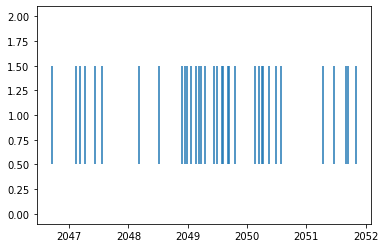

In [260]:
import random

for cell in neurons_trials:
    spikes = trials[0].loc[trials[0]['cell']==cell]
    spike_times = spikes['timestamp']
    plt.eventplot(spike_times)
    break

In [229]:
teste_isi = isi_estimate(list(spike_times))

In [230]:
random.shuffle(teste_isi)

In [287]:
def spike_train_shuffling(spike_times):
    '''
    Shuffles the inter-spike intervals (ISI) in a spike train. Indeed, this preserves the number of spikes,
    the total duration spanned by the spiking activity, the ISI distribution, and the mean rate. On the other hand,
    this annihilates any temporal structure in the spiking activity that could subserve some function.
    
    INPUT: a spike train, as given by a list of the timestamps of instants in which a spike occurs
    OUTPUT: another spike train with the same ISI distribution and number of spikes but shuffled spike positions'''
    
    #just in case it is passed as a DataFrame column and not a list
    spike_times = list(spike_times)
    
    #obtain the ISI
    isi_distribution = isi_estimate(spike_times)
    #and shuffle it
    random.shuffle(isi)
    
    '''since all spike trains are set to begin at t=0, setting the first spike to happen at t=0 is not a problem
    if this is not the case, select a random number - but beware this might make some spike trains longer'''
    current_spike = spike_times[0]
    
    new_spike_train = []
    
    for isi in isi_distribution:
        new_spike_train.append(current_spike)
        #the next spike will be positioned 
        current_spike += isi

    return new_spike_train

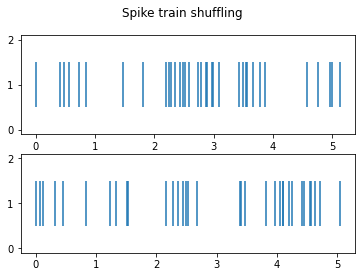

In [242]:
new_spike_train = []
current_spike = 0

for isi in teste_isi:
    new_spike_train.append(current_spike)
    current_spike = current_spike + isi
    #current_spike += isi
    
fig, axs = plt.subplots(2)
fig.suptitle('Spike train shuffling')
axs[0].eventplot(spike_times)
axs[1].eventplot(new_spike_train)

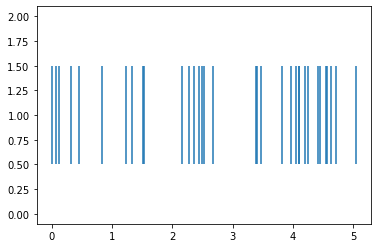

In [236]:
plt.eventplot(new_spike_train)

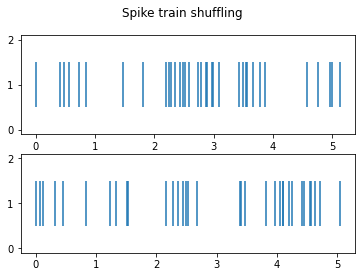

In [237]:
fig, axs = plt.subplots(2)
fig.suptitle('Spike train shuffling')
axs[0].eventplot(spike_times)
axs[1].eventplot(new_spike_train)

In [203]:
def isi_estimate(spike_times):
    '''Estimates the inter-spike interval (ISI) from a list of spike times (i.e. spikes_data['timestamp'])
    
    INPUT: A list of the instants in which spikes were fired
    OUTPUT: A list of inter-spike intervals for adjacent events'''

    isi = []
    for timestamp in range(len(spike_times)-1):
        current_isi = spike_times[timestamp+1] - spike_times[timestamp]
        isi.append(current_isi)
    return isi

In [370]:
def neurons_in_all_trials(trials_dataset):
    '''Checks the global intersection in the sets of neurons that are active in each trial
    
    INPUT: A dataset that is spikes_data-like but split between trials, as returned by separate_into_trials()
    OUTPUT: A list of dataframes containing only the neurons that are active in each and every trial'''
    
    labels = []
    for trial in trials_dataset:
        labels.append(trial.cell.unique())

    sets = [set(label) for label in labels]
    test_set = sets.pop(0)

    for neurons in sets:
        test_set.intersection_update(neurons)
    
    neurons_trials = np.array(list(test_set))

    data = []

    for trial in trials_dataset:
      data.append(trial[trial['cell'].isin(neurons_trials)])

    return data

def gen_spiketrain_list(spikes_dataset):
    '''Splits the dataset into a list whose elements are the subsets comprising the spikes of each neuron
    
    INPUT: spikes DataFrame with two colums (timestamps for spikes and whose neuron it is)
    OUTPUT: a list whose elements are the subsets of the spikes Dataframe (with the same structure) for each neuron
    ''' 
    
    neurons = spikes_dataset['cell'].unique()
    spiketrain_list = []
    
    for neuron in neurons: 
        split_dataset = spikes_dataset.loc[spikes_dataset['cell'] == neuron]
        spiketrain_list.append(split_dataset['timestamp'].to_numpy())

    return spiketrain_list

def spiketrains_per_trial(trials_dataset):
    spiketrains = {}
    for i in range(len(trials_dataset)):
        trial = 'trial_' + str(i+1)
        spiketrains[trial] = gen_spiketrain_list(trials_dataset[i])
  
    return spiketrains

In [371]:
#find the intersection of neurons that are active at every trial/ITI
dfs_neurons_trials = neurons_in_all_trials(trials)
dfs_neurons_ITIs = neurons_in_all_trials(ITIs)

In [376]:
dfs_neurons_trials

[         timestamp  cell
 24559    2046.7083   2.0
 24560    2047.1147   2.0
 24561    2047.1921   2.0
 24562    2047.2679   2.0
 24563    2047.4334   2.0
 ...            ...   ...
 1056259  2050.7781  27.0
 1056260  2051.0686  27.0
 1056261  2051.4120  27.0
 1056262  2051.6796  27.0
 1056263  2051.7772  27.0
 
 [1127 rows x 2 columns],
          timestamp  cell
 24825    2121.5131   2.0
 24826    2121.9715   2.0
 24827    2122.0235   2.0
 24828    2122.1023   2.0
 24829    2122.1281   2.0
 ...            ...   ...
 1056904  2127.5136  27.0
 1056905  2127.5356  27.0
 1056906  2127.5565  27.0
 1056907  2127.7507  27.0
 1056908  2128.0064  27.0
 
 [1404 rows x 2 columns],
          timestamp  cell
 25011    2164.3672   2.0
 25012    2164.4039   2.0
 25013    2164.5222   2.0
 25014    2164.5523   2.0
 25015    2164.5917   2.0
 ...            ...   ...
 1057527  2167.8796  27.0
 1057528  2167.9920  27.0
 1057529  2168.0012  27.0
 1057530  2168.0684  27.0
 1057531  2168.1121  27.0
 
 [774 

In [385]:
max(spikes_dataset['timestamp'])

711.9492

In [395]:
#load data
test_behaviour_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/150628/150628_Behavior.dat',
                     header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python') #Behaviour.dat dataset
test_spikes_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/150628/150628_SpikeData.dat',
                     header=None,names=['timestamp','cell'],engine = 'python') #SpikeData.dat dataset

In [396]:
#adjust times from ms to s
spikes_dataset = time_conversion(test_spikes_dataset,'timestamp') #timestamps now in seconds
behaviour_dataset = time_conversion(test_behaviour_dataset,'trial_start') #trial_start now in seconds
behaviour_dataset = time_conversion(test_behaviour_dataset,'trial_end') #trial_end now in seconds

In [399]:
max(spikes_dataset['timestamp']) - min(spikes_dataset['timestamp'])

453.65897

In [400]:
len(behaviour_dataset)

23